In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Load the preprocessed data

In [2]:
# Load DataFrame from the pickle file
features = pd.read_pickle('features.pkl')
target = pd.read_pickle('target_regression.pkl')

# Split the data to train and test sets

In [3]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 123)

In [29]:
print(X_train.shape)
print(X_test.shape)

(1913, 12)
(479, 12)


# BNN

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchbnn as bnn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tqdm import tqdm

In [6]:
# Tensors for the BNN
X_train_tens = torch.tensor(X_train.values)
y_train_tens = torch.tensor(y_train.values)
X_test_tens = torch.tensor(X_test.values)
y_test_tens = torch.tensor(y_test.values)

In [7]:
num_of_train_data = X_train_tens.shape[0]
print(f"Number of training samples: {num_of_train_data}")

num_of_test_data = X_test_tens.shape[0]
print(f"Number of test samples: {num_of_test_data}")

num_of_inputs = X_train_tens.shape[1]
print(f"Number of inputs: {num_of_inputs}")

Number of training samples: 1913
Number of test samples: 479
Number of inputs: 12


In [8]:
# Training data to a right form for the model
train_dataset = TensorDataset(X_train_tens, y_train_tens)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=False)

In [9]:
# Model
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.3, in_features=num_of_inputs, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=1, bias=True)
)

## Training

In [10]:
# Initializations
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.1
optimizer = optim.Adam(model.parameters(), lr=0.008) 
scheduler = ExponentialLR(optimizer, gamma=0.99)

# Number of training epochs
num_epochs = 200
# Model to the train mode
model.train()  

mse_losses = []
kl_losses = []
epochs = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    mse_total = 0.0
    kl_total = 0.0
    total_batches = 0
    
    for inputs, labels in train_loader: # One batch at a time
        inputs = inputs.to(torch.float32)
        labels = labels.to(torch.float32) 
        
        # Loss
        pre = model(inputs).squeeze()
        mse = mse_loss(pre, labels)
        kl = kl_loss(model)
        cost = mse + kl_weight * kl
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        mse_total += mse.item()
        kl_total += kl.item()
        total_batches += 1
    
    # Mean loss per batch
    avg_mse = mse_total / total_batches
    avg_kl = kl_total / total_batches

    mse_losses.append(avg_mse)
    kl_losses.append(kl_weight * avg_kl)
    epochs.append(epoch + 1) 

    # # Use this if you want to stop the decreasing of the learning rate after some spesific value
    # if scheduler.get_last_lr()[0] > 0.000005:
    scheduler.step()

    if (epoch) % 10 == 0:
        print('Epoch %d - Average MSE: %.3f, Average KL: %.3f, LR: %.5f' % (epoch+1, avg_mse, kl_weight*avg_kl, scheduler.get_last_lr()[0]))

  0%|▍                                                                                 | 1/200 [00:00<01:09,  2.85it/s]

Epoch 1 - Average MSE: 0.879, Average KL: 0.016, LR: 0.00792


  6%|████▊                                                                            | 12/200 [00:02<00:36,  5.19it/s]

Epoch 11 - Average MSE: 0.136, Average KL: 0.031, LR: 0.00716


 11%|████████▉                                                                        | 22/200 [00:04<00:32,  5.53it/s]

Epoch 21 - Average MSE: 0.116, Average KL: 0.034, LR: 0.00648


 16%|████████████▌                                                                    | 31/200 [00:06<00:32,  5.17it/s]

Epoch 31 - Average MSE: 0.083, Average KL: 0.035, LR: 0.00586


 20%|████████████████▌                                                                | 41/200 [00:08<00:28,  5.54it/s]

Epoch 41 - Average MSE: 0.071, Average KL: 0.032, LR: 0.00530


 26%|█████████████████████                                                            | 52/200 [00:10<00:24,  6.00it/s]

Epoch 51 - Average MSE: 0.069, Average KL: 0.029, LR: 0.00479


 31%|█████████████████████████                                                        | 62/200 [00:12<00:22,  6.10it/s]

Epoch 61 - Average MSE: 0.064, Average KL: 0.026, LR: 0.00433


 36%|████████████████████████████▊                                                    | 71/200 [00:13<00:22,  5.85it/s]

Epoch 71 - Average MSE: 0.060, Average KL: 0.024, LR: 0.00392


 41%|█████████████████████████████████▏                                               | 82/200 [00:15<00:20,  5.73it/s]

Epoch 81 - Average MSE: 0.056, Average KL: 0.021, LR: 0.00354


 46%|█████████████████████████████████████▎                                           | 92/200 [00:17<00:18,  5.98it/s]

Epoch 91 - Average MSE: 0.050, Average KL: 0.019, LR: 0.00321


 51%|████████████████████████████████████████▊                                       | 102/200 [00:18<00:16,  5.81it/s]

Epoch 101 - Average MSE: 0.048, Average KL: 0.017, LR: 0.00290


 56%|████████████████████████████████████████████▊                                   | 112/200 [00:20<00:15,  5.79it/s]

Epoch 111 - Average MSE: 0.047, Average KL: 0.016, LR: 0.00262


 61%|████████████████████████████████████████████████▊                               | 122/200 [00:22<00:13,  6.00it/s]

Epoch 121 - Average MSE: 0.046, Average KL: 0.015, LR: 0.00237


 66%|████████████████████████████████████████████████████▊                           | 132/200 [00:24<00:10,  6.22it/s]

Epoch 131 - Average MSE: 0.045, Average KL: 0.014, LR: 0.00214


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [00:25<00:09,  6.16it/s]

Epoch 141 - Average MSE: 0.047, Average KL: 0.014, LR: 0.00194


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [00:27<00:08,  5.86it/s]

Epoch 151 - Average MSE: 0.044, Average KL: 0.013, LR: 0.00175


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [00:29<00:06,  6.00it/s]

Epoch 161 - Average MSE: 0.042, Average KL: 0.013, LR: 0.00159


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [00:30<00:04,  5.84it/s]

Epoch 171 - Average MSE: 0.042, Average KL: 0.012, LR: 0.00143


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [00:32<00:03,  5.69it/s]

Epoch 181 - Average MSE: 0.043, Average KL: 0.012, LR: 0.00130


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [00:34<00:01,  5.88it/s]

Epoch 191 - Average MSE: 0.042, Average KL: 0.012, LR: 0.00117


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:35<00:00,  5.57it/s]


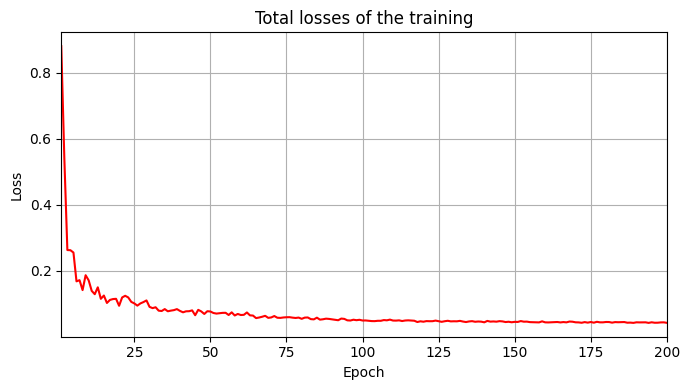

In [11]:
# Figure of the loss

plt.figure(figsize=(7,4))

# Total loss (MSE + KL)
total_losses = [mse + kl_weight * kl for mse, kl in zip(mse_losses, kl_losses)]
plt.plot(epochs, total_losses, linestyle='-', color='red')

plt.xlim(1, epochs[-1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total losses of the training')
plt.grid(True)
plt.tight_layout()

In [12]:
# Computes the mean and standard deviation of predictions across samples
def compute_statistics(predictions, num_samples):

    mean = np.mean(predictions, axis=1)
    std_dev = np.std(predictions, axis=1)
    return mean, std_dev

def inference(model, test_loader, num_samples=50):
    # Initialize model for evaluation mode
    model.eval()
    
    # Store predictions and associated statistics
    all_means = []
    all_std_devs = []

    with torch.no_grad():
        for batch in test_loader:  # Iterate through each batch of test data
            inputs = batch[0].to(torch.float32)  # Ensure inputs are in the correct type
            batch_predictions = []

            # Run the same input batch multiple times (num_samples) to obtain a distribution
            for _ in range(num_samples):
                outputs = model(inputs)  # Forward pass to get predictions
                batch_predictions.append(outputs.cpu().numpy())  # Collect predictions

            # Convert batch predictions to numpy array
            batch_predictions = np.stack(batch_predictions, axis=1)

            # Calculate means and standard deviations of predictions
            means, std_devs = compute_statistics(batch_predictions, num_samples)
            all_means.append(means)
            all_std_devs.append(std_devs)

    # Combine results from all batches
    all_means = np.concatenate(all_means, axis=0)
    all_std_devs = np.concatenate(all_std_devs, axis=0)

    return all_means, all_std_devs

# Format test data for inference function
test_dataset = TensorDataset(X_test_tens) 
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Run inference for regression to obtain means and standard deviations
all_means, all_std_devs = inference(model, test_loader, num_samples=40)

# Results

## Numerical

In [14]:
true_values = y_test.to_numpy().astype(float)  # Ground truth values
predicted_values = all_means  # The predicted mean values from the inference function

In [15]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(true_values, predicted_values)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Absolute Error (MAE): 0.1590


In [16]:
from sklearn.metrics import r2_score
r2 = r2_score(true_values, predicted_values)
print(f"R² Score: {r2:.4f}")

R² Score: 0.9537


The model has a Mean Absolute Error (MAE) of 0.1590, which indicates that, on average, the model's predictions deviate from the actual GPA values by approximately 0.16 points. The R² score of 0.9537 suggests that the model explains 95.37% of the variance in the GPA data, demonstrating a strong fit and high predictive accuracy.

## Visual

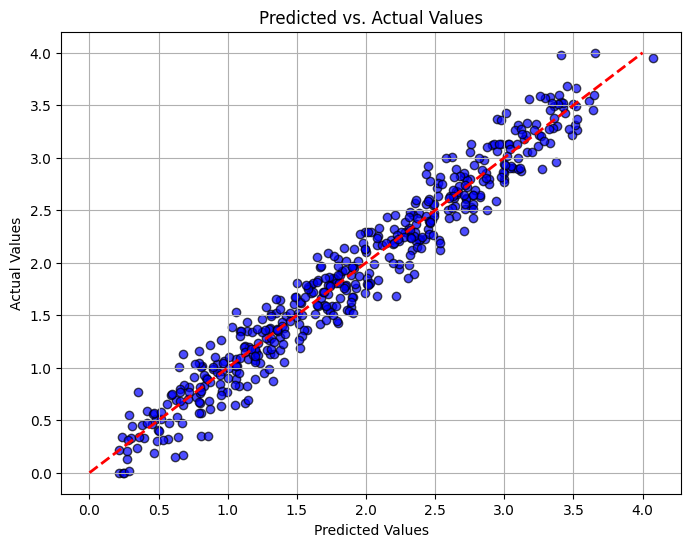

In [17]:
import matplotlib.pyplot as plt

# Scatter plot of true values vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, true_values, alpha=0.7, color='blue', edgecolors='k')
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], color='red', linestyle='--', linewidth=2)
plt.title('Predicted vs. Actual Values')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.grid()
plt.show()

The scatter plot of predicted vs. actual GPA values shows that the majority of the data points are closely aligned along the diagonal line, indicating accurate predictions. While there is some slight variation, there are no visible outliers or funnel shapes, suggesting good overall model performance with minimal bias or variance.

In [25]:
print(true_values.shape)  # Check the shape of actual values
print(predicted_values.shape)  # Check the shape of predicted values

(479,)
(479, 1)


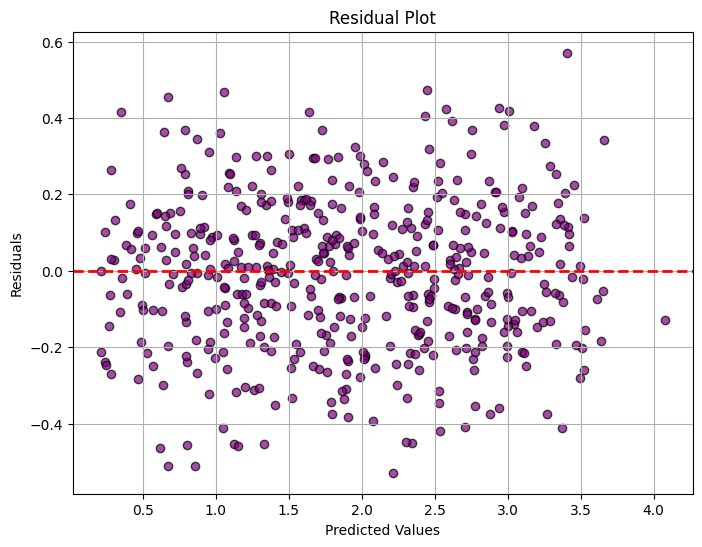

In [28]:
# predicted values need to be flattened to 1D array, so then the shapes are identical
predicted_values = predicted_values.flatten()

# Residuals
residuals = true_values - predicted_values

# Residual plot
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, residuals, alpha=0.7, color='purple', edgecolors='k')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()
plt.show()

The residual plot shows that the differences between the predicted and actual GPA values are mostly centered around zero, with no clear patterns or biases. The spread of residuals remains consistent, indicating that the model performs well across all GPA ranges, without any noticeable outliers or signs of increasing or decreasing variance.